# The color atlas

### Imports

In [1]:
show_plots = True
import matplotlib 
if show_plots:
#     matplotlib.use('Qt5Agg')
    %matplotlib inline

In [2]:
import numpy as np
import scipy.interpolate as intp
import matplotlib.pyplot as plt
from numpy import cos, sin
from mpl_toolkits.mplot3d import axes3d
from colormath.color_objects import sRGBColor, XYZColor
from colormath.color_conversions import convert_color

# 1. Get color matching functions (from the CIE study)

* These define the "tangent space" from the black point (and inverted, from the white point).
* We draw rays from each point through the color matching functions.
* These will draw a "double cone" and intersect at the "characteristic colors".

In [3]:
# this is in XYZ space
MF = np.genfromtxt("CMF_5nm.csv", delimiter=',')
cmf = MF[:, 1:4]

# sum of each component (we use when normalizing)
NORM = sum(cmf)

# achromatic beam -- using uniform for now -- get the whitepoint from this value
# the achromatic beam "scales" the CMF function in XYZ space
abeam = np.ones(cmf.shape[0])
wtpt = cmf.T@abeam

### Add 'purple' colors and make a uniform CMF

In [4]:
ucmf = [c/np.linalg.norm(c) for c in cmf]

# add mixtures of extremal points (red and blue)
# making convex combinations of the endpoints of the CMF to "close" the CMF curve

# Note: The spline has to close, so this has to go from 0 to 1!!
NUMBER_MIXTURE_PTS = 30
coeffs = np.linspace(0, 1, NUMBER_MIXTURE_PTS)
c1 = ucmf[-1]
c0 = ucmf[0]
mixture = []
for c in coeffs:
    mix = c*c0 + (1-c)*c1
    mixture.append(mix/np.linalg.norm(mix))
units = np.concatenate((ucmf, mixture))

### Make continuous "spline" from CMF functions

In [5]:
I = np.linspace(0, 2*np.pi, len(units))
x_spline = intp.make_interp_spline(I, units[:, 0])
y_spline = intp.make_interp_spline(I, units[:, 1])
z_spline = intp.make_interp_spline(I, units[:, 2])

In [6]:
num_upsampled_pts = int(1e6)
vec = lambda s: np.array([x_spline(s), y_spline(s), z_spline(s)])
input_pts = np.linspace(0, 2*np.pi, num_upsampled_pts + 1)
spline_pts = vec(input_pts)

# 2. Rotate the frame to put whitepoint on an axis

In [7]:
# http://scipp.ucsc.edu/~haber/ph216/rotation_12.pdf
def get_rot_matrix(n, t):
    n1,n2,n3 = n[0],n[1],n[2]
    return np.array([
        [cos(t) + n1*n1 * (1 - cos(t)), n1*n2*(1 - cos(t)) - n3*sin(t), n1*n3*(1 - cos(t)) + n2*sin(t)],
        [n1*n2*(1 - cos(t)) + n3*sin(t), cos(t) + n2*n2*(1 - cos(t)), n2*n3*(1 - cos(t)) - n1*sin(t)],
        [n1*n3*(1 - cos(t)) - n2*sin(t), n2*n3*(1 - cos(t)) + n1*sin(t), cos(t) + n3*n3*(1 - cos(t))],
    ])

In [8]:
# move [x,y,z] to [0,r,0]
uwtpt = wtpt/np.linalg.norm(wtpt)
cross = np.cross(uwtpt, [0,1,0])
theta = np.arccos(np.dot(uwtpt, [0,1,0]))
assert np.allclose(uwtpt, get_rot_matrix(cross/np.linalg.norm(cross), -theta) @ [0,1,0])
assert np.allclose([0,1,0], get_rot_matrix(cross/np.linalg.norm(cross), theta) @ uwtpt)

### Rotate to the $(\rho, white, \theta)$ frame (using cylindrical coordinates)

In [9]:
rot = get_rot_matrix(cross/np.linalg.norm(cross), theta)
rotated_spline_pts = rot @ spline_pts # TODO rename to "cmf_points" or something

In [10]:
# some extra magic to make sure we get the whole angle from [0,2pi)
# TODO -- I should de"clever" this..
get_theta = lambda v:  np.sign(v[2])*np.arccos(v[0] / (v[0]**2 + v[2]**2)**0.5) \
     - np.sign(v[2]) * np.pi + np.pi

In [11]:
thetas = get_theta(rotated_spline_pts)

### Ensure the CMF function is monotonic (up to period) in $\theta$

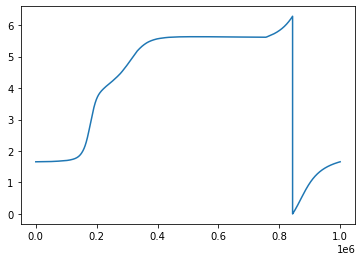

In [12]:
plt.plot(thetas)

# 3. Locate the characteristic points

* The way we do that is by identifying $CMF(\theta)$ with $wtpt - CMF(\theta+\pi)$.
* These two vectors will intersect at a point on the characteristic color locus.

### Identify every $CMF(\theta)$ with $CMF(\theta+\pi)$.

Divide $\theta$ uniformly, and find the closest $CMF$ upsampled point for each $\theta$.

In [13]:
# might be easier to see this with linspace
N = 1000
symmetric_thetas = np.arange(N)/N*2*np.pi

For each $\theta$, find the nearest upsampled point to $\theta$ and $\theta+\pi$


In [14]:
# if we need perf boost:
# use https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

# index of upsampled point with closest "theta" value
indices = []
complement_indices = []

for t in symmetric_thetas:
    closest_pt = np.argmin(abs(thetas - t))
    tolerance = abs(t -thetas[closest_pt])
    assert tolerance < 1e-3, "delta theta for " + str(t) + ":" +  str(tolerance)
    indices.append(closest_pt)
    
    t_plus_pi = (t + np.pi) % (2*np.pi)
    closest_complement_pt = np.argmin(abs(t_plus_pi - thetas))
    tolerance = abs(t_plus_pi -thetas[closest_complement_pt])
    assert tolerance < 1e-3, "delta theta for " + str(t_plus_pi) + ":" + str(tolerance)
    complement_indices.append(closest_complement_pt)

### Now we solve the matrix to locate the characteristic color point.

Could be worth illustrating with a half-diamond picture , why this makes sense.

$k v(t) + \ell v(t+\pi) = (0,wtpt)$

Now get the char color point
```
(vx(t), vx(t+pi)) ( k ) = (0)
(vy(t), vy(t+pi)) ( l ) = (|wtpt|)
```

In [15]:
char_pts = []
for i in range(N):
    # find v(t), v(t+pi)
    vt = rotated_spline_pts[:, indices[i]]
    vt_plus_pi = rotated_spline_pts[:, complement_indices[i]]

    # build and solve matrix
    matrix = np.array([
        vt[0:2],
        vt_plus_pi[0:2]
    ]).T
    k, l = np.linalg.inv(matrix) @ [0, np.linalg.norm(wtpt)]

    # check solution
    diff = np.linalg.norm(k * vt - (rot @ wtpt - l * vt_plus_pi))
    try:
        assert diff < .01, "norm of difference of k vt and complement vector at theta=" + str(symmetric_thetas[i]) + ":" + str(diff)
    except:
        print('diff for t=' + str(symmetric_thetas[i]) + ' too high, trying again..')
        
        # if solution fails, maybe x-value is really small. use z instead.
        matrix = np.array([
            vt[1:3],
            vt_plus_pi[1:3]
        ]).T
        k, l = np.linalg.inv(matrix) @ [np.linalg.norm(wtpt), 0]
        
        # check solution
        diff = np.linalg.norm(k * vt - (rot @ wtpt - l * vt_plus_pi))
        assert diff < .01, "norm of difference of k vt and complement vector at theta=" + str(symmetric_thetas[i]) + ":" + str(diff)

    # save point
    char_pts.append(k * vt)

diff for t=1.5707963267948966 too high, trying again..
diff for t=4.71238898038469 too high, trying again..


Un rotate the frame to get the characteristic points in XYZ space.

In [16]:
orig_char_pts = [np.linalg.inv(rot) @ c for c in char_pts]

### Plot characteristic points

Sanity check: They should all intersect at the gray point

In [17]:
def clip2rgb(xyz):
    if type(xyz) is not XYZColor:
        xyz = XYZColor(xyz[0], xyz[1], xyz[2])
    crgb = convert_color(xyz, sRGBColor)
    r = crgb.rgb_r
    g = crgb.rgb_g
    b = crgb.rgb_b
    r = r if r > 0 else 0
    g = g if g > 0 else 0
    b = b if b > 0 else 0
    r = r if r < 1 else 1
    g = g if g < 1 else 1
    b = b if b < 1 else 1
    return [r, g, b]

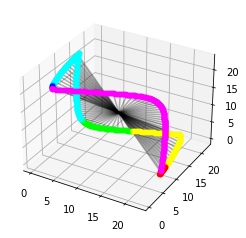

In [18]:
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in orig_char_pts:
        ax.scatter(c[0], c[1], c[2], color=clip2rgb(c))

    half_pts = int(len(orig_char_pts)/2)
    for i in range(half_pts)[::10]:
        pt1 = orig_char_pts[i]
        pt2 = orig_char_pts[i + half_pts]
        ax.plot((pt1[0], pt2[0]), (pt1[1], pt2[1]), (pt1[2], pt2[2]), alpha=0.3, color='black')

### Check intersections (should all be the same)

given $a - t(b - a) = c + s(d - c)$


```
d1-c1  b1-a1  (s) = a1-c1
d2-c2  b2-a2  (t) = a2-c2
(3 is an extra constraint)
```

In [19]:
import random
for _ in range(10000):
    half_pts = int(len(orig_char_pts)/2)
    idx1 = random.randint(0, half_pts - 1)
    idx2 = random.randint(0, half_pts - 1)
    a = orig_char_pts[idx1]
    b = orig_char_pts[idx1 + half_pts]
    c = orig_char_pts[idx2]
    d = orig_char_pts[idx2 + half_pts]

    matrix = np.array([
        [d[0]-c[0], b[0] - a[0]],
        [d[1]-c[1], b[1] - a[1]],
    ])
    if _ % 1000 == 0:
        print(np.linalg.inv(matrix) @ [a[0] - c[0], a[1] - c[1]])
    assert np.allclose((0.5*(a + b)) * 2, wtpt, rtol=1e-03), ((0.5*(a + b)) * 2 - wtpt)
print("looks good")

[ 0.50005433 -0.49994185]
[ 0.50000348 -0.50000284]
[ 0.50000221 -0.49999675]
[ 0.49999776 -0.500001  ]
[ 0.4999351  -0.50006834]
[ 0.49989132 -0.50000528]
[ 0.51146699 -0.51146038]
[ 0.49998948 -0.49999252]
[ 0.49999876 -0.50000131]
[ 0.50000328 -0.50000529]
looks good


From the above calculations, the gray point is halfway on the achromatic axis!

# 4. Upsample characteristic points and cut into equal volumes


In [20]:
def volume(a,b,c):
    # https://en.wikipedia.org/wiki/Tetrahedron#Volume
    # black point: (0,0,0)
    # volume: |a * (b x c) | / 6
    return abs(a.dot(np.cross(b, c))) / 6

In [21]:
def get_partition(xspline, yspline, zspline, wtpt, trials, N):
    # 1. split spline into a bunch of tiny points
    vec = lambda s: np.array([xspline(s), yspline(s), zspline(s)])
    input_pts = np.linspace(0, 2*np.pi, trials + 1)
    spline_pts = vec(input_pts)
    
    # 2. calculate the volume for each wedge
    volumes = [volume(wtpt, spline_pts[:, i], spline_pts[:, i+1]) for i in range(trials)]
    
    # 3. fitting routine to get the equal partitions
    # (keep adding points until the volume is above 1/N)
    # this will make the last wedge a little small
    target = sum(volumes)/N
    new_pts = [0]
    new_volumes = []
    i = 0
    while i < len(volumes):
        v = 0
        while v < target and i < len(volumes):
            v += volumes[i]
            i += 1
        new_pts.append(i)
        new_volumes.append(v)
    return new_pts, new_volumes, spline_pts[:, new_pts]

Now do it!

In [22]:
%%time

# get x,y,z points
xvec, yvec, zvec = np.array(orig_char_pts).T

# make the spline periodic 
xvec = np.concatenate((xvec, [xvec[0]]))
yvec = np.concatenate((yvec, [yvec[0]]))
zvec = np.concatenate((zvec, [zvec[0]]))

# fit 3 pre-mensuration splines (continuous function)
I = np.linspace(0, 2*np.pi, len(orig_char_pts)+1)
x_spline = intp.make_interp_spline(I, xvec)
y_spline = intp.make_interp_spline(I, yvec)
z_spline = intp.make_interp_spline(I, zvec)


# get equal spline pts
_, _, equal_spline_pts = get_partition(x_spline, y_spline, z_spline, wtpt, trials=int(5e5), N=100)

CPU times: user 16.7 s, sys: 164 ms, total: 16.8 s
Wall time: 16.6 s


### Plot characteristic points

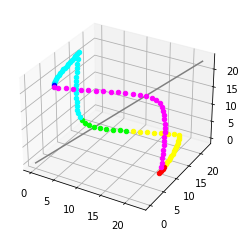

In [23]:
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for s in (equal_spline_pts).T:
        ax.scatter(s[0], s[1],s[2], color=clip2rgb(s))
    ax.plot((0,wtpt[0]),(0,wtpt[1]), (0,wtpt[2]), color='gray')

In [24]:
# thetas corresponding to equally spaced characterstic points
equal_thetas = get_theta(rot @ equal_spline_pts)

# 5. Map the double cone to the optimal color solid

### Question: Do semichromes lie on line from gray point to characteristic colors?
Does it depend on achromatic point?

Let's assume this is true. Then we can plot the semichromes from the intersection of the optimal color solid to the line from gray point to char point.

We know that $cc(\lambda_0) = wtpt - cc(\lambda_f)$ for semichromes with transition points $\lambda_0, \lambda_f$.

But that means $cc(\lambda_0)$ and $cc(\lambda_f)$ are offset by $\pi$ on the characteristic double cone.

This is something we could email Koenderink about...

In [25]:
# makes a "on/off" optimal function with a different value from x0 to xf
def bump(I, x0, xf):
    out = np.zeros(len(I))
    if x0 < xf:
        out[x0:xf] = 1
    elif x0 > xf:
        out[x0:] = 1
        out[0:xf] = 1
    return out

# returns the Optimal color in XYZ space with transition wavelengths wl1 and wl2
def Optimal(wl1, wl2, cmf, abeam, normalized=False):
    """
    Optimal windowing function with wrapping
    """
    abeam_matrix = np.diag(abeam)
    X =  np.dot(abeam_matrix@cmf[:,0], bump(cmf, wl1, wl2))
    Y =  np.dot(abeam_matrix@cmf[:,1], bump(cmf, wl1, wl2))
    Z =  np.dot(abeam_matrix@cmf[:,2], bump(cmf, wl1, wl2))
    XYZ = [X, Y, Z]
    if normalized:
        return (XYZ[0]/NORM[0], XYZ[1]/NORM[1], XYZ[2]/NORM[2])
    else:
        return (XYZ[0], XYZ[1], XYZ[2])

### Create the optimal color "grid"

In [26]:
# number of CMF points
L = cmf.shape[0]

# all optimal colors we can calculate
optimal_color_grid = []
for i in range(0, L, 1):
    v = []
    for j in range(0, L, 1):
        O = Optimal(i, (i+j)%L, cmf, abeam)
        v.append(O)
    optimal_color_grid.append(v)
optimal_color_grid = np.array(optimal_color_grid)

In [27]:
optimal_color_grid.T[0].shape

(89, 89)

### Upsample the optimal color grid

In [28]:
from scipy.interpolate import RectBivariateSpline as Rspl

In [29]:
I = np.linspace(0, 1, 89)
spx = Rspl(I, I, optimal_color_grid.T[0])
spy = Rspl(I, I, optimal_color_grid.T[1])
spz = Rspl(I, I, optimal_color_grid.T[2])
v = lambda s: np.array([spx(*s)[0][0], spy(*s)[0][0], spz(*s)[0][0]])

In [30]:
%%time
N = 1001
r = np.linspace(0, 1, N)
opt_solid = np.zeros((N, N, 3))
for idx, i in enumerate(r):
    for jdx, j in enumerate(r):
        opt_solid[idx, jdx] = v((i,j))

CPU times: user 12.3 s, sys: 35.1 ms, total: 12.3 s
Wall time: 12.3 s


In [31]:
opt_solid.shape

(1001, 1001, 3)

### Map optimal point grid from characteristic colors

We find "even spacings" of the optimal color solid by:
* separating the achromatic axis evenly ("axial points")
* taking each (even-volume-spaced) characteristic point and draw a line to every axial point
* intersecting with the upsampled optimal color grid to get the correct points

In [32]:
def calc_optimal_pt_mesh(opt_solid, v1, v2):
    resh = opt_solid.reshape(-1, 3)
    ll = np.min((v1, v2), axis=0)
    ur = np.max((v1, v2), axis=0)
    resh = resh[np.all((ll <= resh) & (resh <= ur), axis=1)]
    mv1 = resh - v1
    mv2 = resh - v2
    results = np.linalg.norm(np.cross(mv1, mv2), axis=1)
    return np.argmin(results), resh[np.argmin(results)], np.min(results)

In [33]:
num_axial = 15
axial_points = np.array([i*wtpt for i in np.linspace(0, 1, num_axial)])
print(len(axial_points))
spline_line_pts = equal_spline_pts[:, :-1:4].T
print(spline_line_pts.shape[0])

15
25


In [34]:
%%time
# vectorizing this eventually might be a good idea
best_optimal_pts = np.zeros((len(spline_line_pts), len(axial_points), 3))
for i1, v1 in enumerate(spline_line_pts):
    for i2, v2 in enumerate(axial_points):
        c = calc_optimal_pt_mesh(opt_solid, v1, v2)
        best_optimal_pts[i1][i2] = c[1]

CPU times: user 12.9 s, sys: 63.6 ms, total: 13 s
Wall time: 13 s


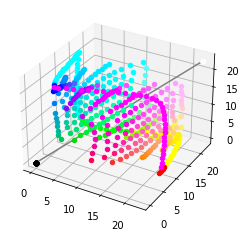

In [35]:
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot((0,wtpt[0]),(0,wtpt[1]), (0,wtpt[2]), color='gray')
    for s in equal_spline_pts.T:
        ax.scatter(s[0], s[1], s[2], color=clip2rgb(s))

    for i1, s in enumerate(spline_line_pts):
        for i2, a in enumerate(axial_points):
            c = best_optimal_pts[i1, i2]
            d = (c[0]/NORM[0], c[1]/NORM[1], c[2]/NORM[2])
            ax.scatter(c[0], c[1], c[2], color=clip2rgb(d))

# 6. Map optimal color solid to sphere

This is a direct mapping, from a sphere's vector to the closest vector on the optimal color solid.

However, eventually we want the equator on the sphere to map to the semichromes. 
* There's a tilt!
* JP will look at the "orange slice" method -- cutting horizontal slices in the sphere and mapping them
* There might be another way to parameterize (theta, phi) to map to the ellipsoid, where phi = pi/2 is always on the semichrome locus, and phi gets squeezed or stretched from the black/white points to the semichrome axis

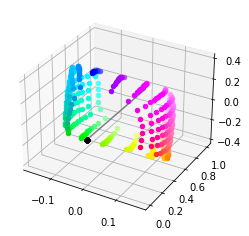

In [36]:
# plot normalized by wtpt
if show_plots:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    r = rot@wtpt / np.linalg.norm(wtpt)
    ax.plot((0,r[0]),(0,r[1]), (0,r[2]), color='gray')
    for i1, s in enumerate(spline_line_pts):
        for i2, a in enumerate(axial_points):
            c = best_optimal_pts[i1, i2] 
            d = (c[0]/NORM[0], c[1]/NORM[1], c[2]/NORM[2])
            ax.scatter(*(rot @ c)/ np.linalg.norm(wtpt), color=clip2rgb(d))


Need to convert from sphere coordinates to optimal color coordinates
* wtpt goes to 001
* black point to 00(-1)

In [37]:
# rot around x, from y to z (pi/2)
rotyz = np.array([
    [1,0,0],
    [0,0,-1],
    [0,1,0]
])
assert np.allclose(rotyz @ [0,1,0], [0,0,1])
assert np.allclose(rotyz @ [0,0,1], [0,-1,0])

In [38]:
def convert(v):
    return rotyz @ (2*(rot @ v / np.linalg.norm(wtpt))) - [0,0,1]

def get_color_from_opt(c):
    d = (c[0]/NORM[0], c[1]/NORM[1], c[2]/NORM[2])
    return clip2rgb(d)

In [39]:
optimal_pts_for_sphere = [convert(b) for b in best_optimal_pts.reshape(-1,3)]
vectors_for_sphere = [o/np.linalg.norm(o) for o in optimal_pts_for_sphere]

In [40]:
def find_closest_opt_color(xyz):
    u = xyz/np.linalg.norm(xyz)
    dots = [v.dot(u) for v in vectors_for_sphere]
    m = np.argmax(dots)
    b = best_optimal_pts.reshape(-1, 3)[m]
    return np.array(get_color_from_opt(b))

### Plot colors on sphere

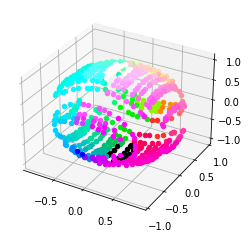

In [41]:
if show_plots:
    xs = np.random.random(10)
    ys = np.random.random(10)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    for x in xs:
        for y in ys:
            zsq = (1-x**2-y**2)
            if zsq >= 0:
                for f in [-1,1]:
                    for g in [-1,1]:
                        for h in [-1,1]:
                            c = [f*x,g*y,h*zsq**0.5]
                            ax.scatter(*c, color=find_closest_opt_color(c))
#                             ax.scatter(*(rot.T @ np.array(c)[[1,2, 0]]), color=find_closest_opt_color(c))